In [1]:
# Load packages
import numpy as np 
import pandas as pd
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
# Load data from the csv file
df = pd.read_csv('loan_data.csv', index_col=None)

# Change the dots in the column names to underscores
df.columns = [c.replace(".", "_") for c in df.columns]
print(f"Number of rows/records: {df.shape[0]}")
print(f"Number of columns/variables: {df.shape[1]}")
df.head()

Number of rows/records: 9578
Number of columns/variables: 14


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# Understand your variables
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
    
# Join with the variables dataframe
var_dict = pd.read_csv('variable_explanation.csv', index_col=0)
variables.set_index('Variable').join(var_dict)



,Number of unique values,Values,Explanation
Variable,,,
credit_policy,2,"[1, 0]",1 if the customer meets the credit underwritin...
purpose,7,"[debt_consolidation, credit_card, all_other, h...",The purpose of the loan.
int_rate,249,"[0.1189, 0.1071, 0.1357, 0.1008, 0.1426, 0.078...",The interest rate of the loan (more risky borr...
installment,4788,"[829.1, 228.22, 366.86, 162.34, 102.92, 125.13...",The monthly installments owed by the borrower ...
log_annual_inc,1987,"[11.35040654, 11.08214255, 10.37349118, 11.299...",The natural log of the self-reported annual in...
dti,2529,"[19.48, 14.29, 11.63, 8.1, 14.97, 16.98, 4.0, ...",The debt-to-income ratio of the borrower (amou...
fico,44,"[737, 707, 682, 712, 667, 727, 722, 677, 662, ...",The FICO credit score of the borrower.
days_with_cr_line,2687,"[5639.958333, 2760.0, 4710.0, 2699.958333, 406...",The number of days the borrower has had a cred...
revol_bal,7869,"[28854, 33623, 3511, 33667, 4740, 50807, 3839,...",The borrower's revolving balance (amount unpai...


In [4]:
#data summary
print(df.describe()) 

       credit_policy     int_rate  installment  log_annual_inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days_with_cr_line     revol_bal   revol_util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.0000

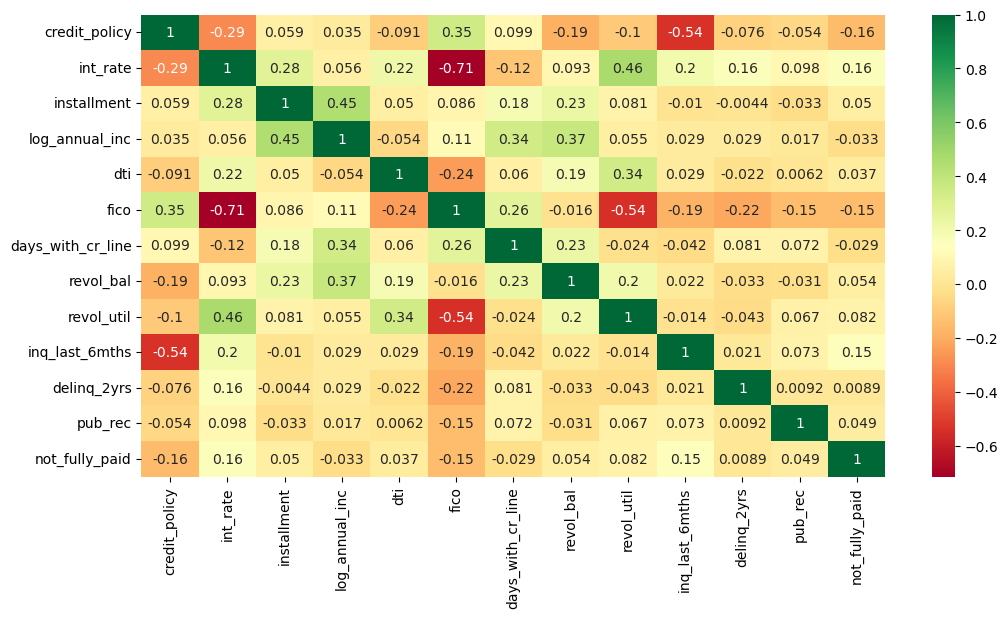

In [5]:
# find correlation between variables
corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap="RdYlGn")
plt.show()

In [6]:
df.isnull().sum() #null values check

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
not_fully_paid       0
dtype: int64

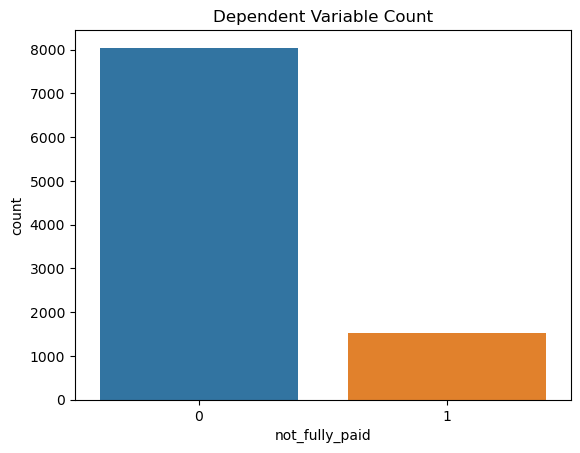

In [7]:
warnings.catch_warnings ()
# view count of paid and unpaid loans
sns.countplot(x=df['not_fully_paid'])
plt.title("Dependent Variable Count")
plt.show()

# 0 represents load paid and 1 represents loan not paid

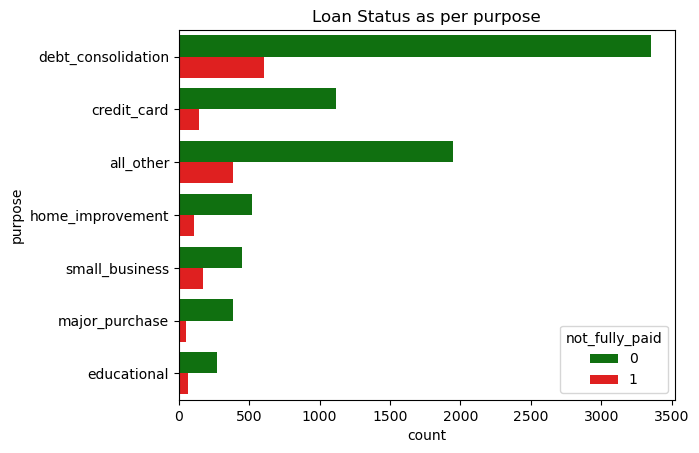

In [8]:
sns.countplot(y=df['purpose'], hue=df['not_fully_paid'], palette={'Green','Red'})
plt.title("Loan Status as per purpose")
plt.show()

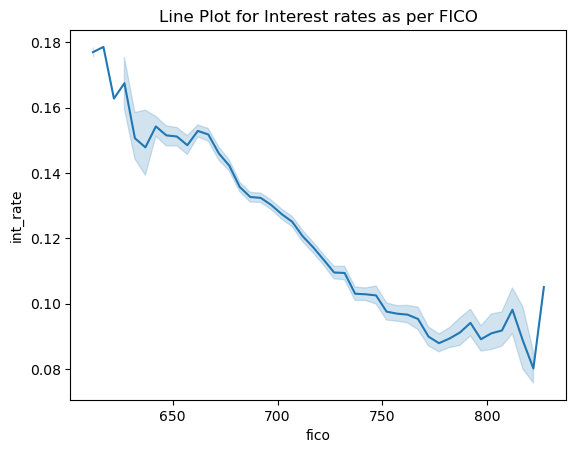

In [9]:
sns.lineplot(x=df['fico'],y=df['int_rate'])
plt.title("Line Plot for Interest rates as per FICO")
plt.show()

#interest rates are inversely related to FICO

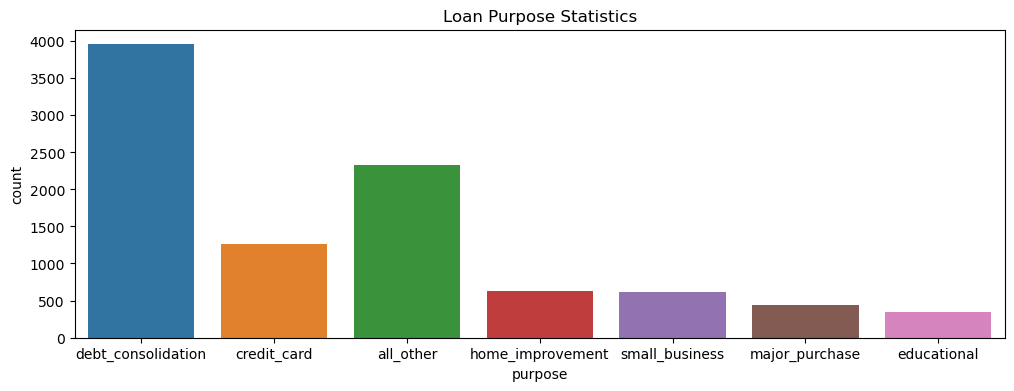

In [10]:
plt.figure(figsize=(12,4))
sns.countplot(x=df['purpose'])
plt.title("Loan Purpose Statistics")
plt.show()

# most number of loan taken are for debt_consolidation and least are educational

In [11]:
# finding what people take loan for which purpose

#calculate median annual income, median fico as per loan purpose
df1=df.groupby("purpose")[['log_annual_inc','fico']].agg(np.median)

#getting count of each type of loan purpose
df1['count']=df["purpose"].value_counts()

#set index as column in dataframe
df1['loan_purpose']=df1.index

#reset index
df1= df1.reset_index()
#print database
df1

,purpose,log_annual_inc,fico,count,loan_purpose
0,all_other,10.839581,712.0,2331,all_other
1,credit_card,11.050890,707.0,1262,credit_card
2,debt_consolidation,10.903815,697.0,3957,debt_consolidation
3,educational,10.596635,707.0,343,educational
4,home_improvement,11.184421,722.0,629,home_improvement
5,major_purchase,10.828042,722.0,437,major_purchase
6,small_business,11.156251,717.0,619,small_business


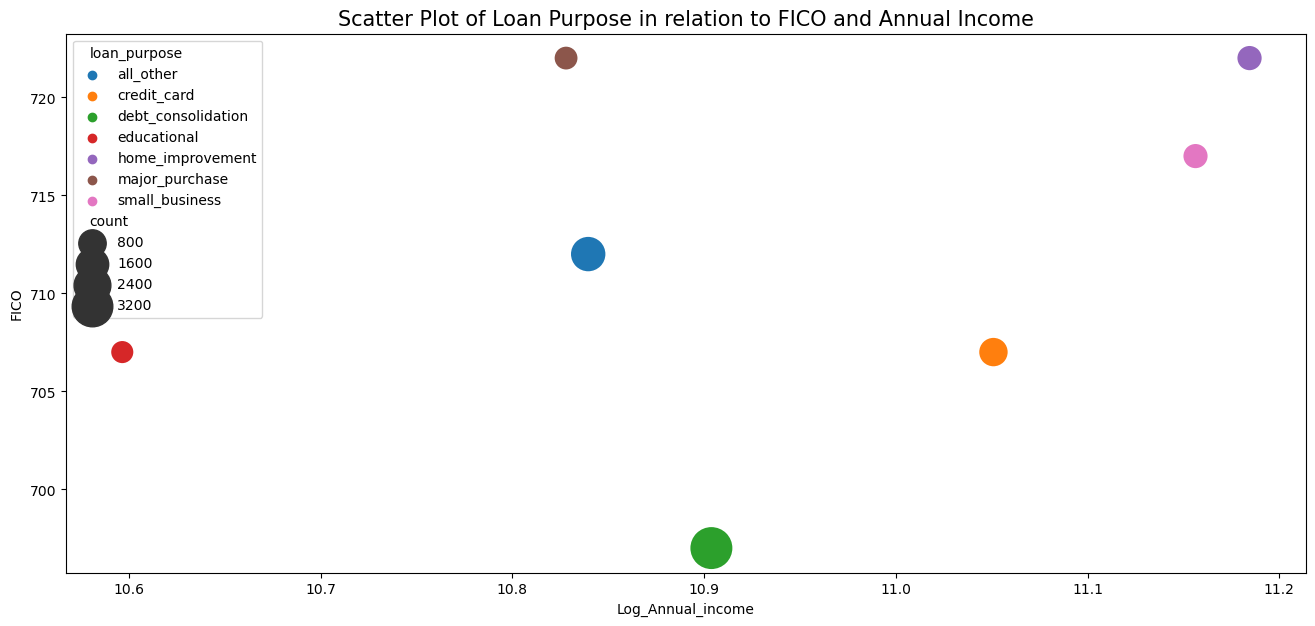

In [12]:
# scatterplot to visualize loan purpose as per annual income and FICO

plt.figure(figsize=(16,7)) #set plot figure size
sns.scatterplot(x = "log_annual_inc", y = "fico", data = df1, hue = "loan_purpose", size="count", sizes=(300,1000)) # scatter plot
plt.title("Scatter Plot of Loan Purpose in relation to FICO and Annual Income", fontsize = 15) # title of scatter plot
plt.xlabel("Log_Annual_income", fontsize = 10) # x-axis label
plt.ylabel("FICO", fontsize = 10) # y-axis label
plt.show() # show scatter plot

#people with higher income and FICO have taken home_improvement loan and people with lower income and FICO have taken educational loan

In [13]:
#assign numeric value to purpose
df.purpose[df['purpose']=='debt_consolidation']=1
df.purpose[df['purpose']=='credit_card']=2
df.purpose[df['purpose']=='small_business']=3
df.purpose[df['purpose']=='major_purchase']=4
df.purpose[df['purpose']=='home_improvement']=5
df.purpose[df['purpose']=='educational']=6
df.purpose[df['purpose']=='all_other']=7

In [14]:
x=df.drop(['not_fully_paid'], axis=1) # variables
y=df['not_fully_paid'] # dependent variable

# split data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

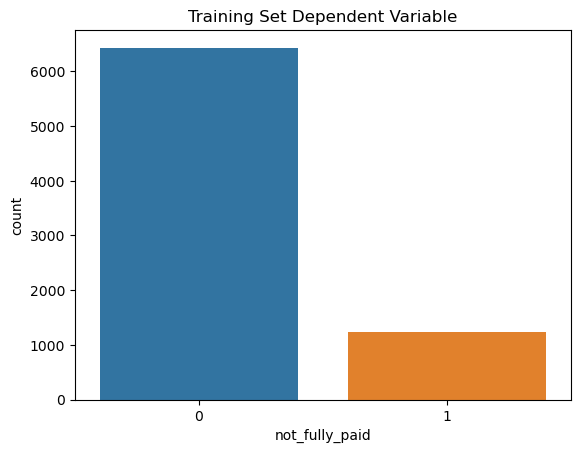

In [15]:
# dependent variable in training set
sns.countplot(x=y_train)
plt.title("Training Set Dependent Variable")
plt.show()

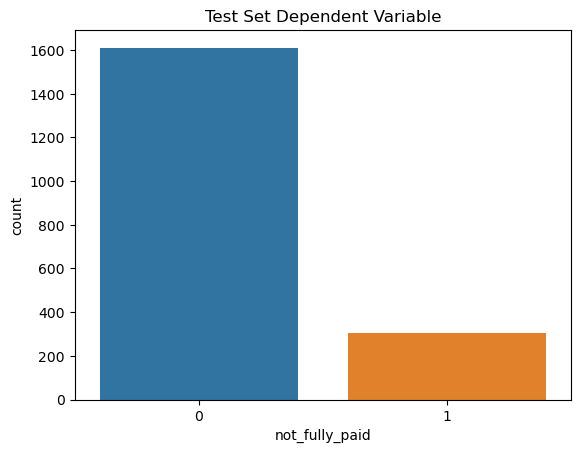

In [16]:
# dependent variable in test set
sns.countplot(x=y_test)
plt.title("Test Set Dependent Variable")
plt.show()

In [17]:
# Logistic Regression Implementation
model=LogisticRegression(max_iter=1000)
model.fit(x_train, y_train) # fitting the model
model_prediction = model.predict(x_test) # predicting dependent variable

In [18]:
# calculate accuracy of model prediction
accuracy = accuracy_score(model_prediction,y_test)*100
print("Accuracy given by Logistic regression : ",accuracy)

Accuracy given by Logistic regression :  84.13361169102296


In [19]:
# classification report
print("Classification Report")
print(classification_report(y_test,model_prediction))

Classification Report
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       0.56      0.02      0.03       305

    accuracy                           0.84      1916
   macro avg       0.70      0.51      0.47      1916
weighted avg       0.80      0.84      0.77      1916



In [20]:
# confusion matrix, x=predicted, y=True values
print(confusion_matrix(y_test,model_prediction))

[[1607    4]
 [ 300    5]]
